## Colab Notebook created for ARAP module at UPC ETSETB.

Authors: Juan José Nieto, Josep Vidal, Margarita Cabrera-Bean

# GRID WORLD

## Complete the TODOs you'll find:


1.  Initiate the variable POLICY p(s'|a,s).
2.  Initiate the corresponding rewards in *next_position* function.
3.  Compute the reward vector and the transition probability matrix.
4.  Compute Bellman Equation
-------------------------------------------------
5.  Compute update of the state value
6.  Program Policy Iteration Algorithm
7.  Program Value Iteration Algorithm






---

## Lab 2. GridWorld
#### Alex Carrillo Alza

*Aprenentatge per Reforç i Aprenentatge Profund, Ciència i Enginyeria de Dades (UPC)*

October 26, 2020

---

In [1]:
import numpy as np
import seaborn as sns

from random import random
import matplotlib.pyplot as plt

In the `Grid` class below, we first initiate the variable $p(s'|a,s)$ (*i.e.* the `self.POLICY` matrix) and the corresponding reward $r(s,a,s')$, by giving values for $s,s'=1,\dots,25$ and $a=1,\dots,4$.

In [2]:
class Grid():
    def __init__(self):
        self.N_ROWS = 5
        self.N_COLUMNS = 5
        self.N_STATES = self.N_ROWS * self.N_COLUMNS

        self.GAMMA = 0.9
        self.ZETA_MAX = 1e-3
        self.ITER_MAX = 100
        
        self.ACTIONS = [(0, -1), (1, 0), (0, 1), (-1, 0)]
        self.N_ACTIONS = 4
        
        # 1.TODO: Initialize with equal probability for each action in each state
        self.POLICY = 1/(self.N_ACTIONS)*np.ones((self.N_STATES,self.N_ACTIONS))  # rows sum up 1

        self.SPC_STATES = [(6, 10, 10), (16, 18, 5)] # (ini state, fin state, reward)

        self.TrPrM = np.zeros((self.N_STATES, self.N_STATES))
        self.V_FUNCTION = np.zeros(self.N_STATES)
        self.REWARD = np.zeros(self.N_STATES)


    ''' Convert state s from scalar to coordinates x,y '''
    def get_XY(self, state):
        state -= 1
        return (state % self.N_ROWS, int(state / self.N_ROWS))

    ''' Convert coordinates x,y to scalar state '''
    def get_state(self, state):
        return state[1]*self.N_COLUMNS + state[0] + 1


    '''
    Check if state is special

    Params:
        - int: state [1,...,25]
    Returns:
        - bool: is_special
        - int: next_state
        - int: reward
    '''
    def is_special(self, state):
        for spc in self.SPC_STATES:
            if spc[0] == state:
                return True, spc[1], spc[2]
        return False, None, None



    '''
    Computes next state and reward

    Params:
        - int: state [1,...,25]
    Returns:
        - int: next_state
        - int: reward
    '''
    def next_position(self, state, action):
        (x,y) = self.get_XY(state)
        (ax, ay) = self.ACTIONS[action]

        next_state = (x + ax, y + ay)

        special = self.is_special(state)    # returns (is_special, next_state, reward)

        # 2.TODO: Complete the TODOs with the corresponding rewards
        if special[0]:                                                  # special state
            return special[1], special[2]

        elif next_state[0] > -1 and next_state[0] < self.N_ROWS and \
            next_state[1] > -1 and next_state[1] < self.N_COLUMNS:      # agent within the limits of the grid

            next_state = self.get_state(next_state)
            return next_state, 0

        else:                                                           # agent is trying to overpass the limits of the grid
            return state, -1


### Plot functions

In [3]:
'''Insert title, and axis labels to plots'''
def insert_labels(labels, ax):
    if 'title' in labels:
        ax.set_title(labels['title']) 
    if 'xlabel' in labels:
        ax.set_xlabel(labels['xlabel']) 
    if 'ylabel' in labels:
	    ax.set_ylabel(labels['ylabel'])


'''Plot for showing value functions'''
def plot_heatmap(data, **kwargs):
    fig, ax = plt.subplots()
    sns.heatmap(data, cmap='coolwarm')
    insert_labels(kwargs, ax)

'''Plot for showing how the difference of state-values decrease over time'''
def plot_deltas(data, **kwargs):
    fig, ax = plt.subplots()
    plt.plot(data)
    insert_labels(kwargs, ax)

'''Policy plots. Indicates action taken in each state.'''
def plot_arrow(data, actions, **kwargs):

    fig, ax = plt.subplots()

    U = np.array([[actions[y][0] for y in x] for x in data])
    V = np.array([[actions[y][1] for y in x] for x in data])

    X = np.arange(0, 5, 1)
    Y = np.arange(0, 5, 1)

    q = ax.quiver(X, Y, V, U*-1)
    plt.imshow(data, cmap=plt.cm.Pastel1)
    # ax.quiverkey(q, X=0.3, Y=1.1, U=10, label=' ', labelpos='E')

    insert_labels(kwargs, ax)
    ax.axis('off')
    plt.show()


'''Group of N policy plots.'''
def plot_arrows(data, actions):
    # Only pick 3 first actions matrices and last one (optimal policy)
    num_policies = len(data)

    fdata = data[:min(3, num_policies)] + data[-1:]
    

    fig, ax = plt.subplots(1, len(fdata), figsize=(20,6))
    for i, d in enumerate(fdata):

        U = np.array([[actions[y][0] for y in x] for x in d])
        V = np.array([[actions[y][1] for y in x] for x in d])

        X = np.arange(0, 5, 1)
        Y = np.arange(0, 5, 1)

        q = ax[i].quiver(X, Y, V, U*-1)
        ax[i].imshow(d, cmap=plt.cm.Pastel1)
        # ax[i].quiverkey(q, X=0.3, Y=1.1, U=10,
        #             label=' ', labelpos='E')
        labels = {
            'title': '{} Policy'.format(i if len(fdata)-1 > i else 'Optimal'),
        }
        insert_labels(labels, ax[i])
        ax[i].axis('off')

    plt.show()

## TRANSITION PROBABILITY MATRIX AND UNIFORM POLICY VALUE FUNCTION

If $\pi$ is the equiprobable random policy, we obtain the reward vector $\mathbf{R}^{\pi}$ and the probability matrix $\mathbf{P}^{\pi}$ shown in the Bellman expectation equation system.

In [4]:
grid = Grid()

for s in range(1, grid.N_STATES + 1):
    for a in range(grid.N_ACTIONS):
        
        next_state, reward = grid.next_position(s, a)
        # 3.TODO: Compute reward vector and transition prob matrix. 
        grid.TrPrM[s-1, next_state-1] += grid.POLICY[s-1, a]
        grid.REWARD[s-1] += grid.POLICY[s-1, a]*reward

We draw in a square image the matrix $\mathbf{P}^{\pi}$ or $p(s'|s)$ taking as axis the states $s$ (vertical axe) and $s'$ (horizontal axe).

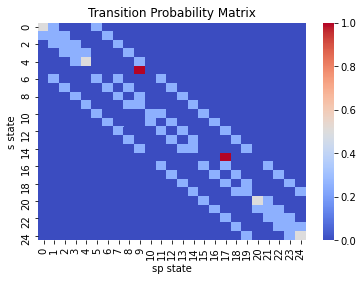

In [5]:
# PLOT TRANSITION MATRIX
conf = {
    'title': 'Transition Probability Matrix',
    'xlabel': 'sp state',
    'ylabel': 's state'
}
plot_heatmap(grid.TrPrM, **conf)



**In total, there are $4^{25}$ deterministic policies.**

In [6]:
4**25

1125899906842624

In the function below we directly implement the solving of the Bellman equation.

Note we can use a different method than inverting the matrix, i.e. Least Squares, in case we need to. However for our 25x25 example, inversion is not a problem at all.

In [7]:
def bellman(P, r, gamma, method = 'inv'):
    P_size = P.shape[0] if len(P.shape) > 1 else 1
    I = np.eye(P_size)
    if method == 'lstsq':
        return np.linalg.lstsq((I - gamma*P), r)[0]     # OPTION 1: approximate by Least Squares 
    else:
        return np.dot(np.linalg.inv((I - gamma*P)), r)  # OPTION 2: invert the matrix!

We solve the Bellman equation with a discount factor $\gamma=0.9$ and draw in a square figure (as Fig. 1) the value function of each state $s$: $\mathbf{v}_{\pi}(s)$.

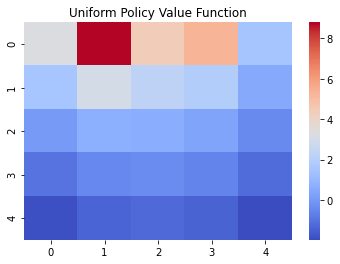

In [8]:
# UNIFORM POLICY VALUE FUNCTION COMPUTATION

# 4.TODO: Compute Bellman Equation

value_f = bellman(grid.TrPrM, grid.REWARD, grid.GAMMA)  # vector of size N_STATES, i.e. 25

vf_matrix = np.transpose(np.reshape(value_f, (grid.N_ROWS, grid.N_COLUMNS)))  # convert vector to matrix, i.e. 5x5 

# PLOT UNIFORM POLICY VALUE F.
conf = {
    'title': 'Uniform Policy Value Function',
}
plot_heatmap(vf_matrix, **conf)

We save the value function matrix to compare it with the following results.

In [9]:
uniform_policy_VF = vf_matrix

## POLICY EVALUATION

We program the **Iterative Policy Evaluation** procedure to iteratively compute $v_{\pi}(s)$, for $s=1,\dots,25$.

In [10]:
'''
In this case we define a function since we will use this algorithm
within 'policy iteration' algorithm
'''
def policy_evaluation(grid):
    zeta = grid.ZETA_MAX + 1
    iter = 0
    v_incr = []

    while zeta > grid.ZETA_MAX and iter < grid.ITER_MAX + 1:
        
        vm_aux = grid.V_FUNCTION.copy()                                 # Store current state-values for later comparison

        for s in range(1, grid.N_STATES + 1):                           # Loop over all the states
            vs_aux = 0
            for a in range(grid.N_ACTIONS):                             # Loop over all actions in each state
                next_state, reward = grid.next_position(s, a)           # Compute next_state and reward when taking action a in state s

                # 5.TODO: Compute update of the state value
                vs_aux += grid.POLICY[s-1, a] * (reward + grid.GAMMA * grid.V_FUNCTION[next_state-1])
        
            grid.V_FUNCTION[s - 1] = vs_aux                             # Update state-value with the result of Bellman Equation
        
        zeta = np.max(np.abs(grid.V_FUNCTION - vm_aux))                 # Compute the difference between current state-values and previous ones
        v_incr.append(zeta)
        iter += 1
    
    return v_incr

In [11]:
grid = Grid()
v_incr = policy_evaluation(grid)

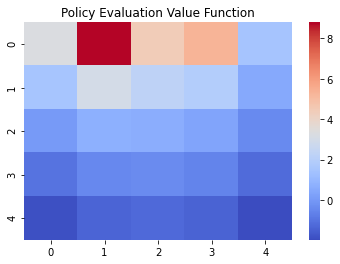

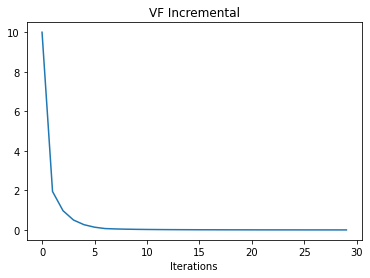

In [12]:
vf_matrix = np.transpose(np.reshape(grid.V_FUNCTION, (grid.N_ROWS, grid.N_COLUMNS)))

conf = {
    'title': 'Policy Evaluation Value Function',
}
plot_heatmap(vf_matrix, **conf)
policy_evaluation_VF = vf_matrix

conf= {
    'title': 'VF Incremental',
    'xlabel': 'Iterations'
}
plot_deltas(v_incr, **conf)


A priori, the result of the plots seems very similar to the one obtained in question c), that is when explicitly solving Bellman equation and seen the Uniform Policy Value Function plot.

Now, when applying iteratively the Bellman expectation equation we get the same results, the heatmap looks the same and it has the same values. Indeed, by rather than inverting the matrix equation, it can be shown that this $\mathbf{v}^\pi_{k+1} = \mathbf{R}^\pi + \gamma\mathbf{P} \mathbf{v}^\pi_k$ iteration converges to $\mathbf{v}_\pi(s)$ as $k \to \infty$. For instance, the VF incremental plot shows how quickly the differences between $\mathbf{v}(s^{k+1})$ and $\mathbf{v}(s^{k})$, *i.e.* the difference between current state-values and previous ones, decays to almost zero and the iterations eventually stop.

Finally, we numerically compare the both value function matrices (*Uniform Policy Value Function* and *Policy Evaluation Value Function*) and we observe that their differences are negligible, in our example.

In [13]:
policy_evaluation_VF - uniform_policy_VF

array([[0.00459926, 0.00363756, 0.00351259, 0.0031934 , 0.00334994],
       [0.00423511, 0.0035965 , 0.00327995, 0.00307771, 0.00304825],
       [0.00404538, 0.00348863, 0.00315037, 0.00295802, 0.00288617],
       [0.00394167, 0.00341029, 0.00307328, 0.0028806 , 0.0027985 ],
       [0.00389612, 0.00337294, 0.00303798, 0.00284505, 0.00276059]])

## POLICY ITERATION

Next, we program  the  **Policy  Iteration  Improvement**  procedure  to  iteratively  compute  an optimum deterministic policy $A(s)$, for $s=1,\dots,25$, *i.e.* a policy such as $p(a|s)=1$ if $A(s)=a$ and $p(a'|s)=0$ for $a' \neq a$.

We make use of the iterative `policy_evaluation()` function programmed in question d).

In [14]:
grid = Grid()

iter = 0
it_max = 10
ac_dif = 1

actions_list = []       # Store actions taken in each state for each run. [[a1, ... , a25], ... , [a1, ... , a25]]
a_inc = []              # Store number of different actions taken in each run.


while ac_dif > 0 and iter < it_max + 1:
    ac_dif = 0
    actions = []
    
    # 6.TODO: Program Policy Iteration Algorithm (you must make use of policy_evaluation function)
    policy_stable = True
    _ = policy_evaluation(grid)
    
    for s in range(1, grid.N_STATES + 1):
        old_action = np.argmax(grid.POLICY[s-1])
        action_values = np.zeros(grid.N_ACTIONS)
        
        for a in range(grid.N_ACTIONS):
            next_state, reward = grid.next_position(s, a)
            action_values[a] += reward + grid.GAMMA * grid.V_FUNCTION[next_state-1]
        
        best_action = np.argmax(action_values)
        actions.append(best_action)
        
        if old_action != best_action:
            policy_stable = False
            ac_dif += 1
            
        grid.POLICY[s-1] = np.eye(grid.N_ACTIONS)[best_action]
        
    #####

    actions_list.append(np.transpose(np.array(actions).reshape(grid.N_ROWS,grid.N_COLUMNS)))
    a_inc.append(ac_dif)

    if policy_stable:
        break
    
    iter += 1

We draw in square figures the value function of each state $s$: $\mathbf{v}_A(s)$ and the optimum policy $A(s)$.

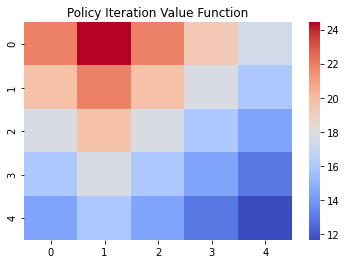

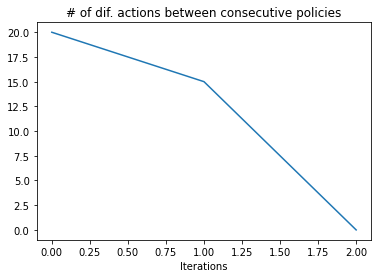

In [15]:
vf_matrix = np.transpose(np.reshape(grid.V_FUNCTION, (grid.N_ROWS, grid.N_COLUMNS)))

conf = {
    'title': 'Policy Iteration Value Function',
}
plot_heatmap(vf_matrix, **conf)
policy_iteration_VF = vf_matrix.copy()

conf= {
    'title': '# of dif. actions between consecutive policies',
    'xlabel': 'Iterations'
}
plot_deltas(a_inc, **conf)



With *policy iteration* algorithm, we first evaluate policy until convergence and then we improve policy. So, as we know, the final policy is an optimal policy given that $\mathbf{v}(s) = max_{a\in \mathcal{A}} q_\pi(s,a) = \mathbf{v}_*(s) \quad \forall s$. That is why we note that the values of the Value Function matrix have increased from $[0,8]$ (in the previous questions) up to $[12,24]$ now (because the policy is optimal, hence its value function is higher).

In policy iteration we now that if improvement stops, the Bellman optimality equation is satisfied. In the "# of dif. actions between consecutive policies" plot we can see that the algorithm has needed only 3 iterations, i.e. it has changed between 3 different policies (well, indeed only 2, because the last one is the same as the previous one). Below we can see them and check that indeed they make sense as the optimal policy led us to best special states:

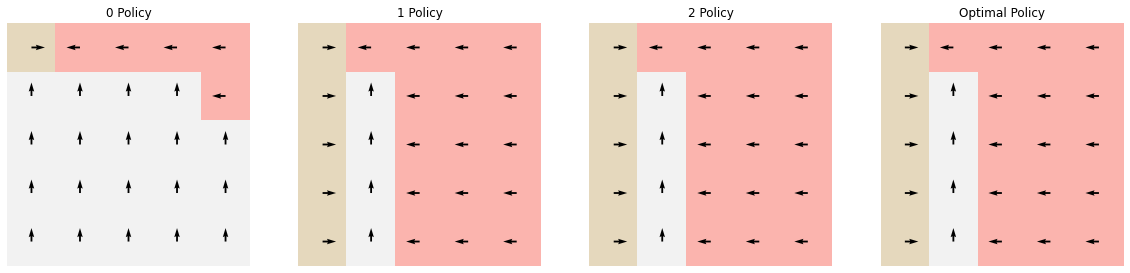

In [16]:
plot_arrows(actions_list, grid.ACTIONS)

## VALUE ITERATION

Finally, we program  the  **Value  Iteration  Improvement**  procedure  to  iteratively  compute  an optimum deterministic policy $A(s)$, for $s=1,\dots,25$, *i.e.* a policy such as $p(a|s)=1$ if $A(s)=a$ and $p(a'|s)=0$ for $a' \neq a$.

In [17]:
grid = Grid()

zeta = grid.ZETA_MAX + 1
iter = 0
v_incr = []
a_inc = []

while zeta > grid.ZETA_MAX and iter < grid.ITER_MAX + 1:
    ac_dif = 0
    vm_aux = grid.V_FUNCTION.copy()

    # 7.TODO: Program Value Iteration Algorithm (do NOT make use of policy_evaluation function)    
    for s in range(1, grid.N_STATES + 1):
        old_action = np.argmax(grid.POLICY[s-1])
        action_values = np.zeros(grid.N_ACTIONS)
        
        for a in range(grid.N_ACTIONS):
            next_state, reward = grid.next_position(s, a)
            action_values[a] += reward + grid.GAMMA * grid.V_FUNCTION[next_state-1]
        
        best_action_value = np.max(action_values)
        best_action = np.argmax(action_values)
        
        if old_action != best_action:
            ac_dif += 1
        
        grid.V_FUNCTION[s-1] = best_action_value
        grid.POLICY[s-1] = np.eye(grid.N_ACTIONS)[best_action]
    
    a_inc.append(ac_dif)                                # Number of actions taken differently from previous iteration
    zeta = np.max(np.abs(grid.V_FUNCTION - vm_aux))     # Compute the difference of the state-values
    v_incr.append(zeta)                                 # Store the difference in v_incr list
    iter += 1

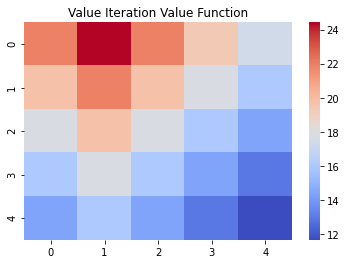

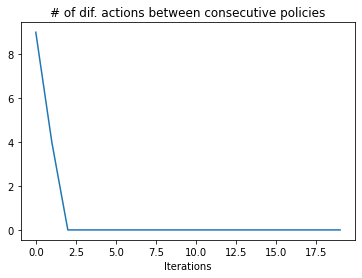

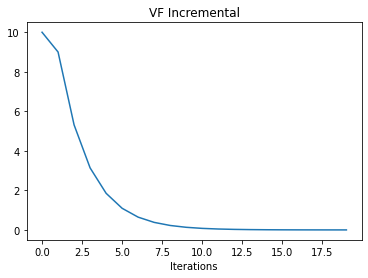

In [18]:
vf_matrix = np.transpose(np.reshape(grid.V_FUNCTION, (grid.N_ROWS, grid.N_COLUMNS)))

conf = {
    'title': 'Value Iteration Value Function',
}
plot_heatmap(vf_matrix, **conf)
value_iteration_VF = vf_matrix.copy()

conf= {
    'title': '# of dif. actions between consecutive policies',
    'xlabel': 'Iterations'
}
plot_deltas(a_inc, **conf)

conf= {
    'title': 'VF Incremental',
    'xlabel': 'Iterations'
}
plot_deltas(v_incr, **conf)


Now, with *value iteration* algorithm we expect the same result, and that is the case. With value iteration we first evaluate value function and then obtain policy, by effectively combine, in each of its sweeps, one weep of policy evaluation and one sweep of policy improvement, like in our code. In fact, we observe that the differences between both *Uniform Policy Value Function* and *Policy Evaluation Value Function* matrices are negligible, in our example:

In [19]:
policy_iteration_VF - value_iteration_VF

array([[0.00098533, 0.00064647, 0.00058183, 0.00064647, 0.00058183],
       [0.0008868 , 0.00058183, 0.00052364, 0.00047128, 0.00042415],
       [0.00079812, 0.00052364, 0.00047128, 0.00042415, 0.00038174],
       [0.00071831, 0.00047128, 0.00042415, 0.00038174, 0.00034356],
       [0.00064647, 0.00042415, 0.00038174, 0.00034356, 0.00030921]])

It is clear that now as we make use of the `grid.ZETA_MAX` $\theta$ parameter the algorithm takes a few more iterations but the VF incremental plot shows a similar behaviour seen before: it decreases at the very first iterations, meaning that the differences between $\mathbf{v}(s^{k+1})$ and $\mathbf{v}(s^{k})$, *i.e.* the difference between current state-values and previous ones, decays to almost zero and the iterations eventually stop.

For the "# of dif. actions between consecutive policies" plot, we see that the number of actions changes between the second iteration and keeps the same until the algorithm stops.

Finally, the optimal policy is show below and, as expected, it is the same as the one obtained with the Policy Iteration algorithm and indeed it is a policy that make sense (it led us to the best special states):

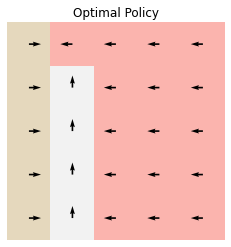

In [20]:
conf= {
    'title': 'Optimal Policy'
}

actions = []
for s in range(1, grid.N_STATES + 1):
    actions.append(np.argmax(grid.POLICY[s-1]))

action_arrows = np.transpose(np.array(actions).reshape(grid.N_ROWS,grid.N_COLUMNS))
plot_arrow(action_arrows, grid.ACTIONS, **conf)